In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
import collections
from array import array

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/'
outputdir = inputdir+'xsec_crt_2D_mar18/' 
output_filedir = outputdir
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')


Welcome to JupyROOT 6.18/04


In [2]:
pot_data =    7.644e+18

outputdir_png, outputdir_root, outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"xsec_crt_2D.root","RECREATE");


In [3]:
#!jupyter nbconvert --to script numuCCana_muon_cut_weight.ipynb

In [4]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# CRT 2D cross section error calculation

In [5]:
##### flux and number of tragets parameters###
flux = 1.16859e11/1.592e20 # flux per POT per cm2
print flux
flux = 7.3789785277e-10
print flux
roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))
print 'Fiducial Volume: ', V_fid
##############################################

beam_flux = flux * pot_data
print 'Beam flux = {:.5e}'.format(beam_flux),' /cm2'
N_tot = roh_data*N_A*N_nucleons*V_fid/mol
print 'Number of target nuclei= {:.5e}'.format(N_tot),' /cm3'

7.34038944724e-10
7.3789785277e-10
Fiducial Volume:  49184671.35
Beam flux = 5.64049e+09  /cm2
Number of target nuclei= 4.10331e+31  /cm3


In [6]:
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/30.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

In [7]:
from array import array
#mom_bins = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
#mom_bins = [ 0.00, 0.225, 0.28, 0.33, 0.39, 0.52, 0.78, 1.21, 2.5]

mom_bins = {}
mom_bins[0] = [ 0.00, 0.18, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[1] = [ 0.00, 0.18, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[2] = [ 0.00, 0.18, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[3] = [ 0.00, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[4] = [ 0.00, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[5] = [ 0.00, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[6] = [ 0.00, 0.30, 0.45, 0.77, 1.28, 2.50 ]
mom_bins[7] = [ 0.00, 0.30, 0.45, 0.77, 1.28, 2.50 ]
mom_bins[8] = [ 0.00, 0.30, 0.45, 0.77, 1.28, 2.50 ]

theta_bins = [ -1.00, -0.50, 0.00, 0.28, 0.47, 0.63, 0.765, 0.865, 0.935, 1.00 ]

len_theta = len(theta_bins) - 1
len_mom = {}
sum_bins = 0
for i in range(len_theta):
    len_mom[i] = len(mom_bins[i]) - 1
    #print len_mom[i]
    sum_bins+=len_mom[i]


In [8]:
path_cv = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/'
f_cv = ROOT.TFile.Open(path_cv+"xsec_filesV4/xsec_2D_wighted.root", 'read')

# fix file: root -l
#            TFile *MyFile = new TFile("All_Genie_theta.root","UPDATE");
#           MyFile->Write()

In [9]:
# get data, ext and dirt from CV file
h_data = []
h_ext = []
h_dirt = []
h_overlay = []
h_dirt_nocrt = []
h_overlay_nocrt = []

for t_bin in range(len_theta):
    h_data.append(f_cv.Get('h_data['+str(t_bin)+']'))
    h_ext.append(f_cv.Get('h_ext['+str(t_bin)+']'))
    h_dirt.append(f_cv.Get('h_dirt['+str(t_bin)+']'))
    h_overlay.append(f_cv.Get('h_overlay['+str(t_bin)+']'))
    h_dirt_nocrt.append(f_cv.Get('h_dirt_nocrt['+str(t_bin)+']'))
    h_overlay_nocrt.append(f_cv.Get('h_overlay_nocrt['+str(t_bin)+']'))

print h_data[0].Integral(0,len_mom[0]+1)
print h_ext[0].Integral(0,len_mom[0]+1)
print h_dirt[0].Integral(0,len_mom[0]+1)
print h_overlay[0].Integral(0,len_mom[0]+1)

88.0
5.80717624724
11.4282898307
28.7172985971


In [10]:
# get background from all genie file
h_eff_tilde = []

for t_bin in range(len_theta):
    h_eff_tilde.append(f_cv.Get('h_1d_eff_tilde['+str(t_bin)+']'))

In [17]:
# calculate xsec for each universe
h_xsec_data = []
h_xsec_crt = []


for t_bin in range(len_theta):
    h_xsec_data.append(h_data[t_bin].Clone())
    h_xsec_data[t_bin].Add(h_ext[t_bin],-1)
    h_xsec_data[t_bin].Add(h_dirt[t_bin],-1)
    h_xsec_data[t_bin].Add(h_overlay[t_bin],-1)

    h_xsec_data[t_bin].Divide(h_eff_tilde[t_bin])
    h_xsec_data[t_bin].Scale(1.0/(N_tot*beam_flux*1e-38))

    for m_bin in range(len_mom[t_bin]):
        h_xsec_data[t_bin].SetBinContent(m_bin+1,h_xsec_data[t_bin].GetBinContent(m_bin+1)/h_xsec_data[t_bin].GetBinWidth(m_bin+1))
        h_xsec_data[t_bin].SetBinError(m_bin+1,h_xsec_data[t_bin].GetBinError(m_bin+1)/h_xsec_data[t_bin].GetBinWidth(m_bin+1))

    bin_width_theta = theta_bins[t_bin+1] - theta_bins[t_bin]
    h_xsec_data[t_bin].Scale(1.0/bin_width_theta)
    
    h_xsec_crt.append(h_data[t_bin].Clone())
    h_xsec_crt[t_bin].Add(h_ext[t_bin],-1)
    #h_xsec_nodirt[t_bin].Add(h_dirt[t_bin],-1)
    
    h_temp = h_dirt_nocrt[t_bin].Clone()
    h_temp.Add(h_dirt[t_bin],-1)
    h_temp.Scale(1.0/10.0)
    h_temp.Add(h_dirt[t_bin])
    #h_dirt_crt = h_temp.Clone()
    
    h_xsec_crt[t_bin].Add(h_temp,-1)
    
    h_temp = h_overlay_nocrt[t_bin].Clone()
    h_temp.Add(h_overlay[t_bin],-1)
    h_temp.Scale(1.0/10.0)
    h_temp.Add(h_overlay[t_bin])
    #h_overlay_crt[t_bin] = h_temp.Clone()
    
    h_xsec_crt[t_bin].Add(h_temp,-1)

    h_xsec_crt[t_bin].Divide(h_eff_tilde[t_bin])
    h_xsec_crt[t_bin].Scale(1.0/(N_tot*beam_flux*1e-38))

    for m_bin in range(len_mom[t_bin]):
        h_xsec_crt[t_bin].SetBinContent(m_bin+1,h_xsec_crt[t_bin].GetBinContent(m_bin+1)/h_xsec_crt[t_bin].GetBinWidth(m_bin+1))
        h_xsec_crt[t_bin].SetBinError(m_bin+1,h_xsec_crt[t_bin].GetBinError(m_bin+1)/h_xsec_crt[t_bin].GetBinWidth(m_bin+1))

    bin_width_theta = theta_bins[t_bin+1] - theta_bins[t_bin]
    h_xsec_crt[t_bin].Scale(1.0/bin_width_theta)


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/png/h_xsec_2D_0_crt.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/pdf/h_xsec_2D_0_crt.pdf has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/png/h_xsec_2D_1_crt.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/pdf/h_xsec_2D_1_crt.pdf has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/png/h_xsec_2D_2_crt.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/pdf/h_xsec_2D_2_crt.pdf has been created
Info in <TCanvas::Print>: png file

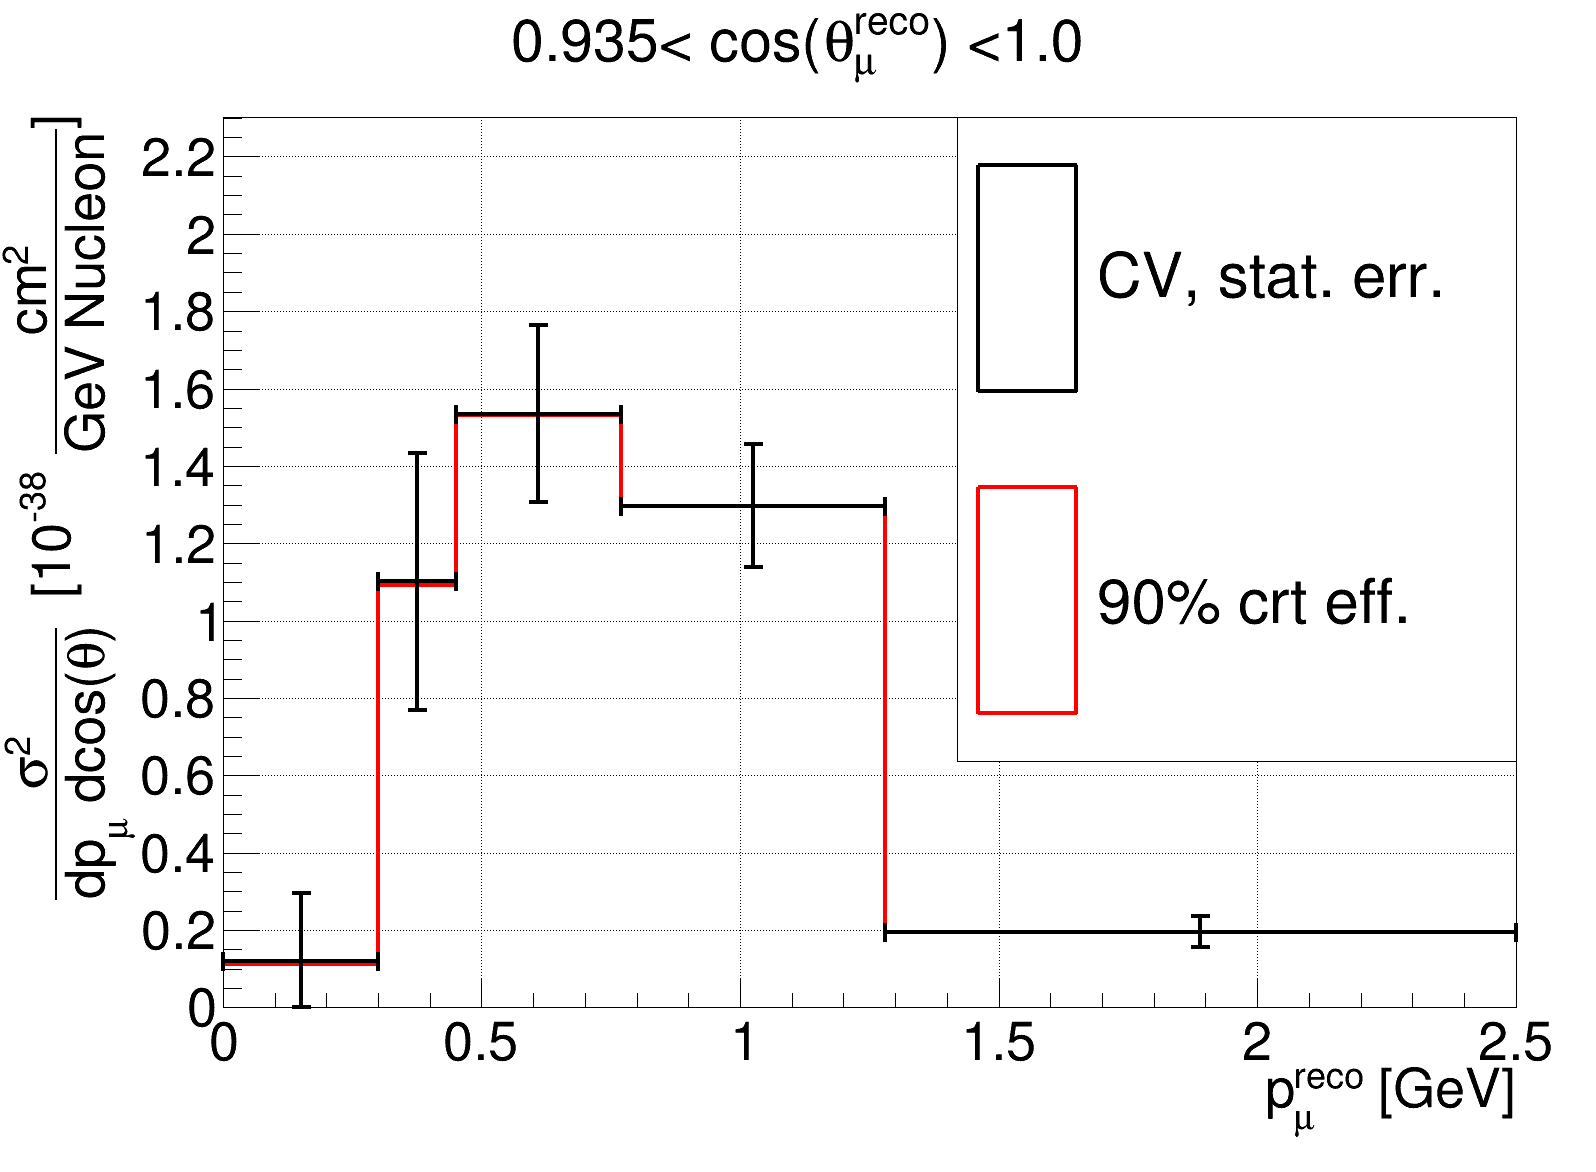

In [20]:
# draw all xsec

ROOT.gStyle.SetOptTitle(1)
ROOT.gStyle.SetEndErrorSize(9)

for t_bin in range(len_theta):
    h_xsec_data[t_bin].GetYaxis().SetTitleSize(0.05)
    h_xsec_data[t_bin].GetYaxis().SetTitleOffset(0.0)
    h_xsec_data[t_bin].GetYaxis().SetLabelSize(0.05)
    h_xsec_data[t_bin].GetXaxis().SetTitleSize(0.05)
    h_xsec_data[t_bin].GetXaxis().SetLabelSize(0.05)
    h_xsec_data[t_bin].GetXaxis().SetTitleOffset(1)
    h_xsec_data[t_bin].SetLineWidth(4)

    h_xsec_data[t_bin].SetLineColor(1)
    h_xsec_data[t_bin].SetTitle(str(theta_bins[t_bin])+'< cos(#theta^{reco}_{#mu}) <'+str(theta_bins[t_bin+1]))
    h_xsec_data[t_bin].SetXTitle("p^{reco}_{#mu} [GeV]")
    h_xsec_data[t_bin].SetYTitle('#frac{#sigma^{2}}{dp_{#mu} dcos(#theta)} \t [10^{-38} #frac{cm^{2}}{GeV Nucleon}]')
    h_xsec_data[t_bin].SetMaximum(-1111)
    h_xsec_data[t_bin].SetMinimum(0)
    h_xsec_data[t_bin].SetMaximum( h_xsec_data[t_bin].GetMaximum()*1.5)
    h_xsec_data[t_bin].Draw('hist')
    
    h_xsec_crt[t_bin].SetLineWidth(4)
    h_xsec_crt[t_bin].SetLineColor(2)
    h_xsec_crt[t_bin].Draw('same hist')

    h_xsec_data[t_bin].Draw('E1 same')
    legend = ROOT.TLegend(0.6,0.35,0.95,0.9); #LEGEND RIGHT
    legend.AddEntry(h_xsec_data[t_bin],'CV, stat. err.',"f")
    legend.AddEntry(h_xsec_crt[t_bin],'90% crt eff.',"f")
    legend.Draw()
    c1.SaveAs(outputdir_png + 'h_xsec_2D_'+str(t_bin)+'_crt.png')
    #c1.SaveAs(globale.outputdir_root + 'h_xsec_2D_'+str(t_bin)+'_dirt.root')
    c1.SaveAs(outputdir_pdf + 'h_xsec_2D_'+str(t_bin)+'_crt.pdf')

    c1.Draw()
            


In [21]:
cov_matrix = np.zeros((sum_bins,sum_bins))
xsec_cv_vec = np.zeros((sum_bins))
xsec_diff_matrix = np.zeros((sum_bins))

bin_counter = 0

for t_bin in range(len_theta):
    #print 'next theta',t_bin
    for m_bin in range(len_mom[t_bin]):
        xsec_cv = h_xsec_data[t_bin].GetBinContent(m_bin+1)
        xsec_cv_vec[bin_counter] = xsec_cv
        xsec_det = h_xsec_crt[t_bin].GetBinContent(m_bin+1)
        xsec_diff_matrix[bin_counter] = xsec_cv-xsec_det

        bin_counter+=1
cov_matrix = xsec_diff_matrix.reshape(sum_bins,1) * xsec_diff_matrix


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/png/h_covariance_crtsys.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/root/h_covariance_crtsys.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/pdf/h_covariance_crtsys.pdf has been created


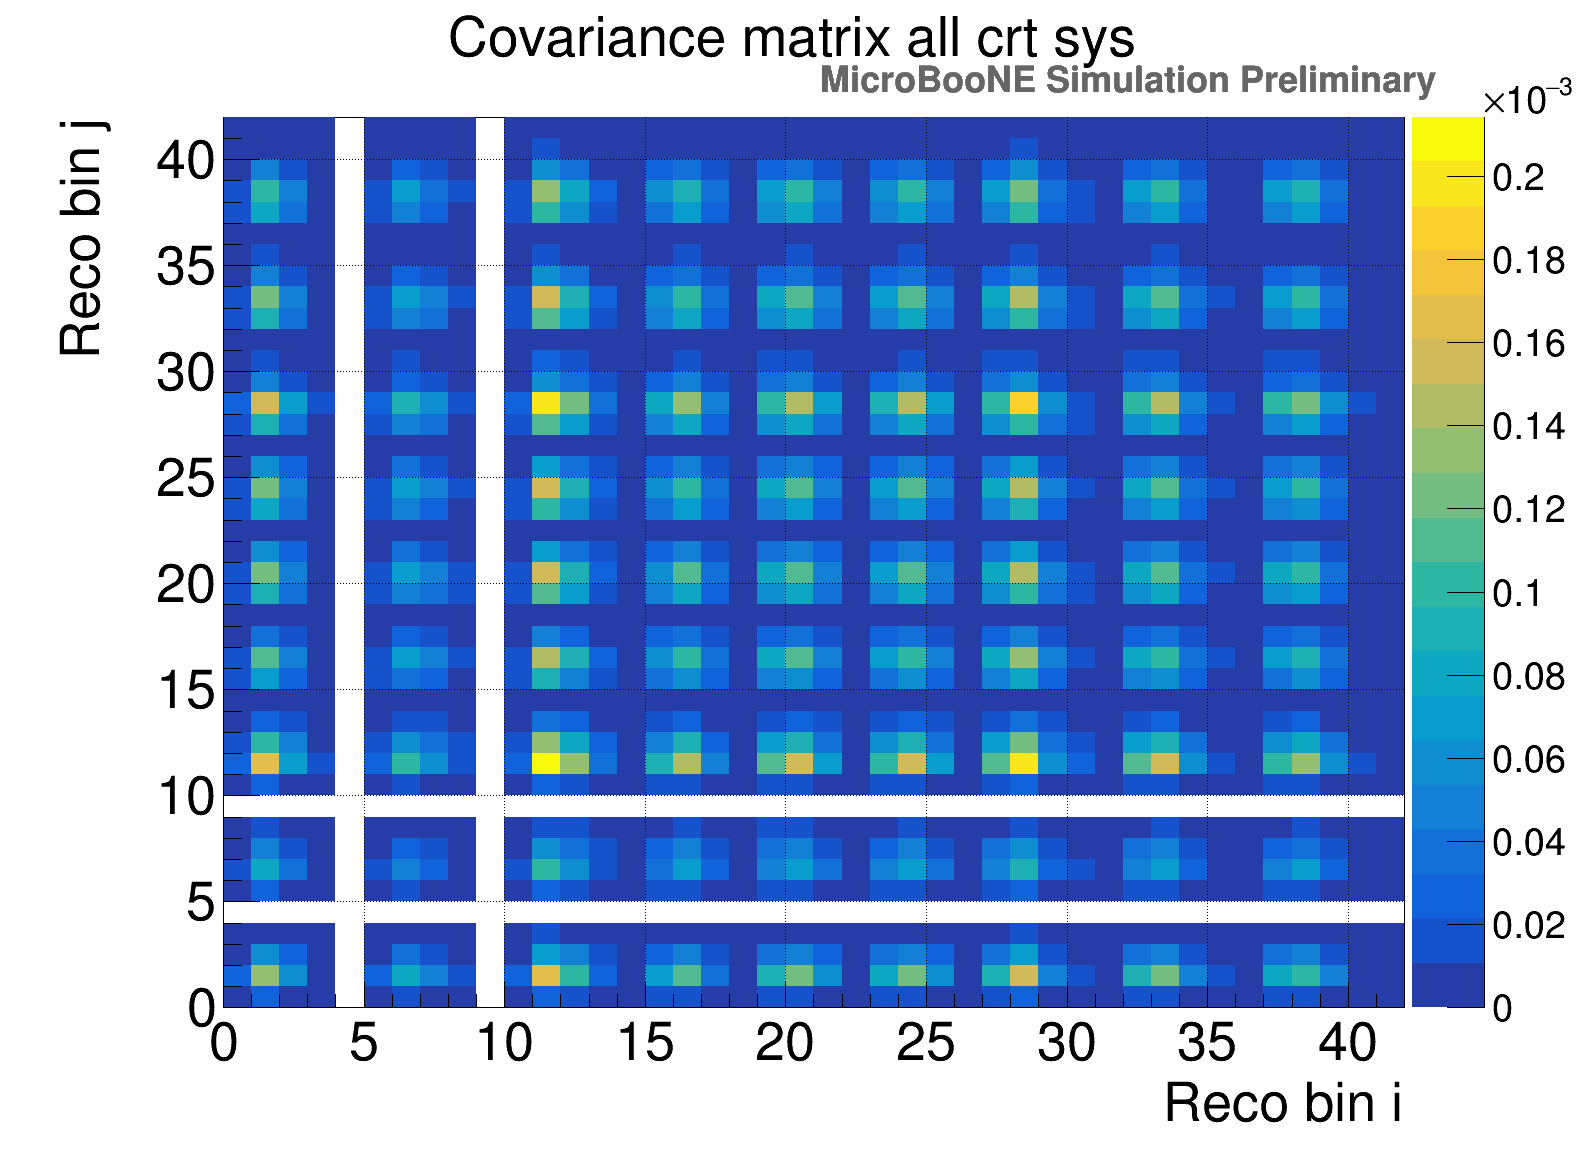

In [23]:
ROOT.gStyle.SetPaintTextFormat('0.6g')
h_covariance = ROOT.TH2D("h_covariance",'Covariance matrix all crt sys',sum_bins,0,sum_bins,sum_bins,0,sum_bins)
for i in range(sum_bins):
    for j in range(sum_bins):
        h_covariance.SetBinContent(i+1,j+1,cov_matrix[i,j])
#h_covariance.SetXTitle("Reco bin i, 7=overflow")
#h_covariance.SetYTitle("True bin j")
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")

h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.12)
ROOT.gStyle.SetPaintTextFormat('0.4g')

h_covariance.Draw('colz')
#h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_covariance_crtsys.png")
c1.SaveAs(outputdir_root + "h_covariance_crtsys.root")
c1.SaveAs(outputdir_pdf + "h_covariance_crtsys.pdf")
#h_covariance.Write('h_covariance')
RootFile = ROOT.TFile(output_filedir+"CRT_systematic_2D.root","update");
h_covariance.Write('h_covariance')
RootFile.Close()  

In [24]:
#correlation matrix
xsec_corr_matrix = np.zeros((sum_bins,sum_bins))
for i in range(sum_bins):
    for j in range(sum_bins):
        xsec_corr_matrix[i][j] = cov_matrix[i][j]/(1e-80+math.sqrt(cov_matrix[i][i]*cov_matrix[j][j]))

#frac covariance matrix
xsec_frac_matrix = np.zeros((sum_bins,sum_bins))
for i in range(sum_bins):
    for j in range(sum_bins):
        #print cov_matrix[i][j]
        xsec_frac_matrix[i][j] = cov_matrix[i][j]/(1e-80+(xsec_cv_vec[i]*xsec_cv_vec[j]))


Warning in <TROOT::Append>: Replacing existing TH1: h_covariance (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/png/h_correlation_crtsys.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/root/h_correlation_crtsys.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/pdf/h_correlation_crtsys.pdf has been created


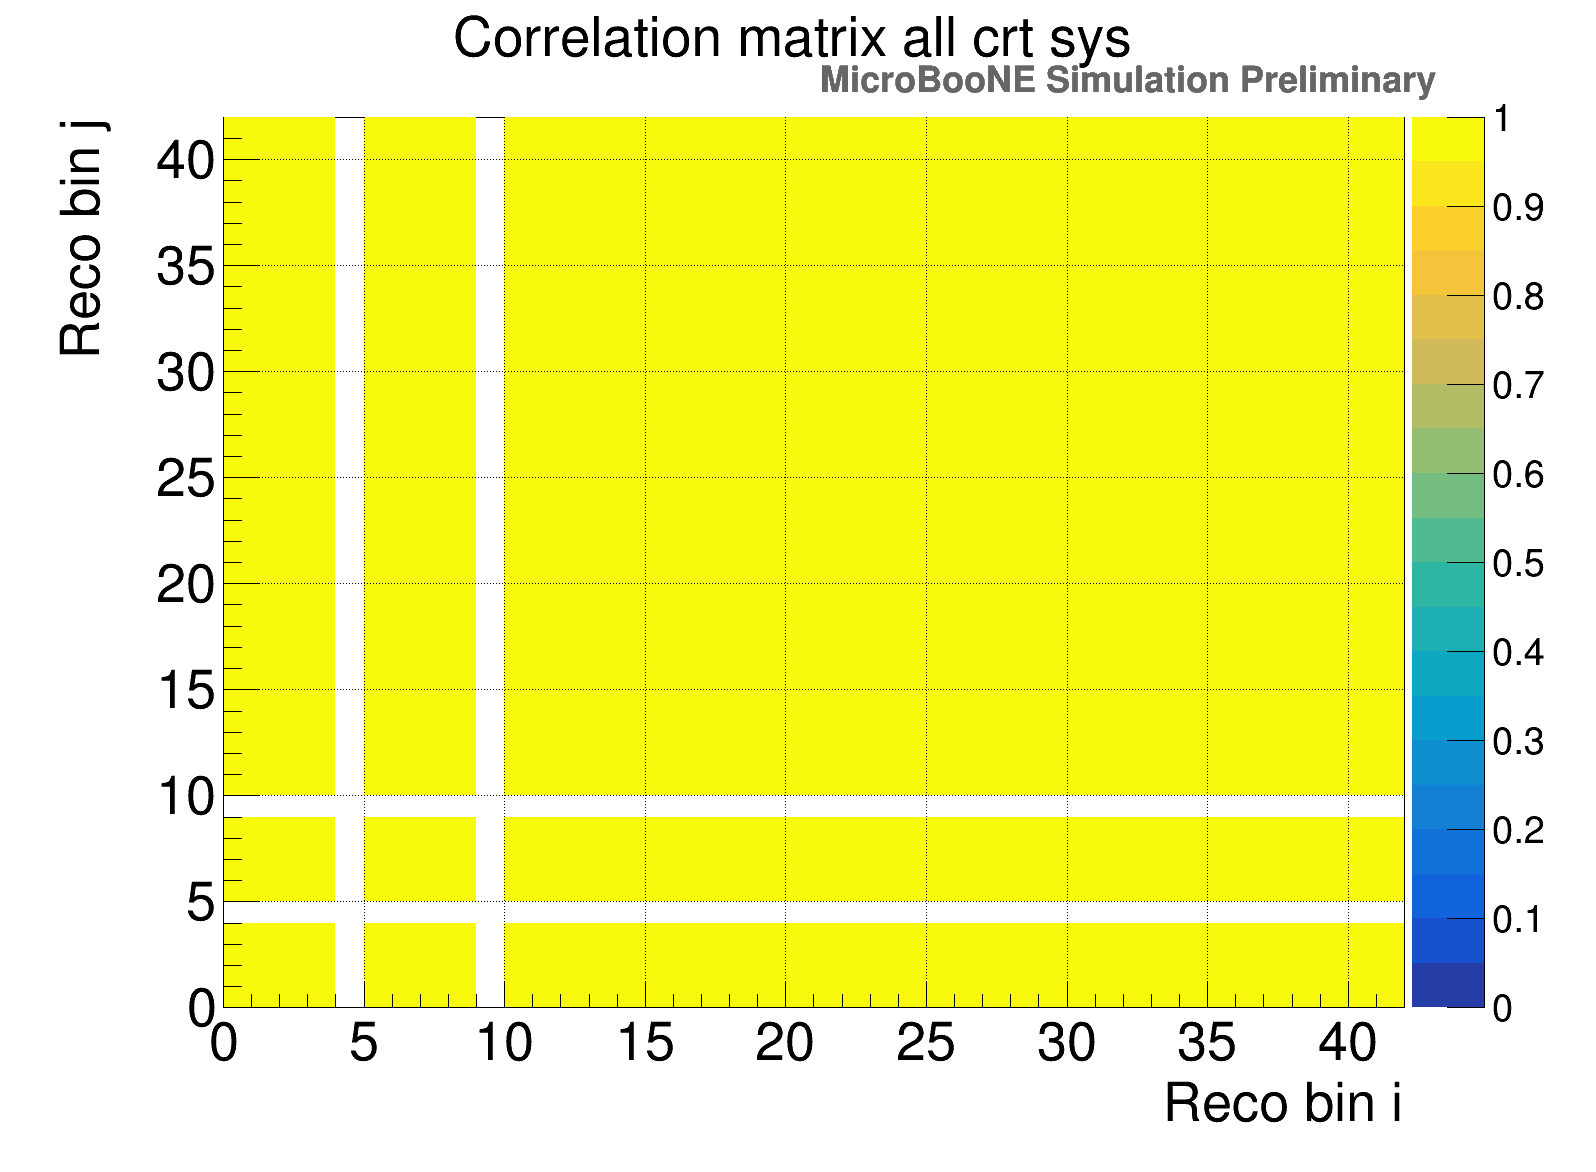

In [25]:
ROOT.gStyle.SetPaintTextFormat('0.6g')
h_covariance = ROOT.TH2D("h_covariance",'Correlation matrix all crt sys',sum_bins,0,sum_bins,sum_bins,0,sum_bins)
for i in range(sum_bins):
    for j in range(sum_bins):
        h_covariance.SetBinContent(i+1,j+1,xsec_corr_matrix[i,j])
#h_covariance.SetXTitle("Reco bin i, 7=overflow")
#h_covariance.SetYTitle("True bin j")
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")

h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.12)
ROOT.gStyle.SetPaintTextFormat('0.4g')

h_covariance.Draw('colz')
#h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_correlation_crtsys.png")
c1.SaveAs(outputdir_root + "h_correlation_crtsys.root")
c1.SaveAs(outputdir_pdf + "h_correlation_crtsys.pdf")
#h_covariance.Write('h_covariance')
RootFile = ROOT.TFile(output_filedir+"Crt_systematic_2D.root","update");
h_covariance.Write('h_correlation')
RootFile.Close()  

Warning in <TROOT::Append>: Replacing existing TH1: h_covariance (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/png/h_frac_crtsys.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/root/h_frac_crtsys.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/pdf/h_frac_crtsys.pdf has been created


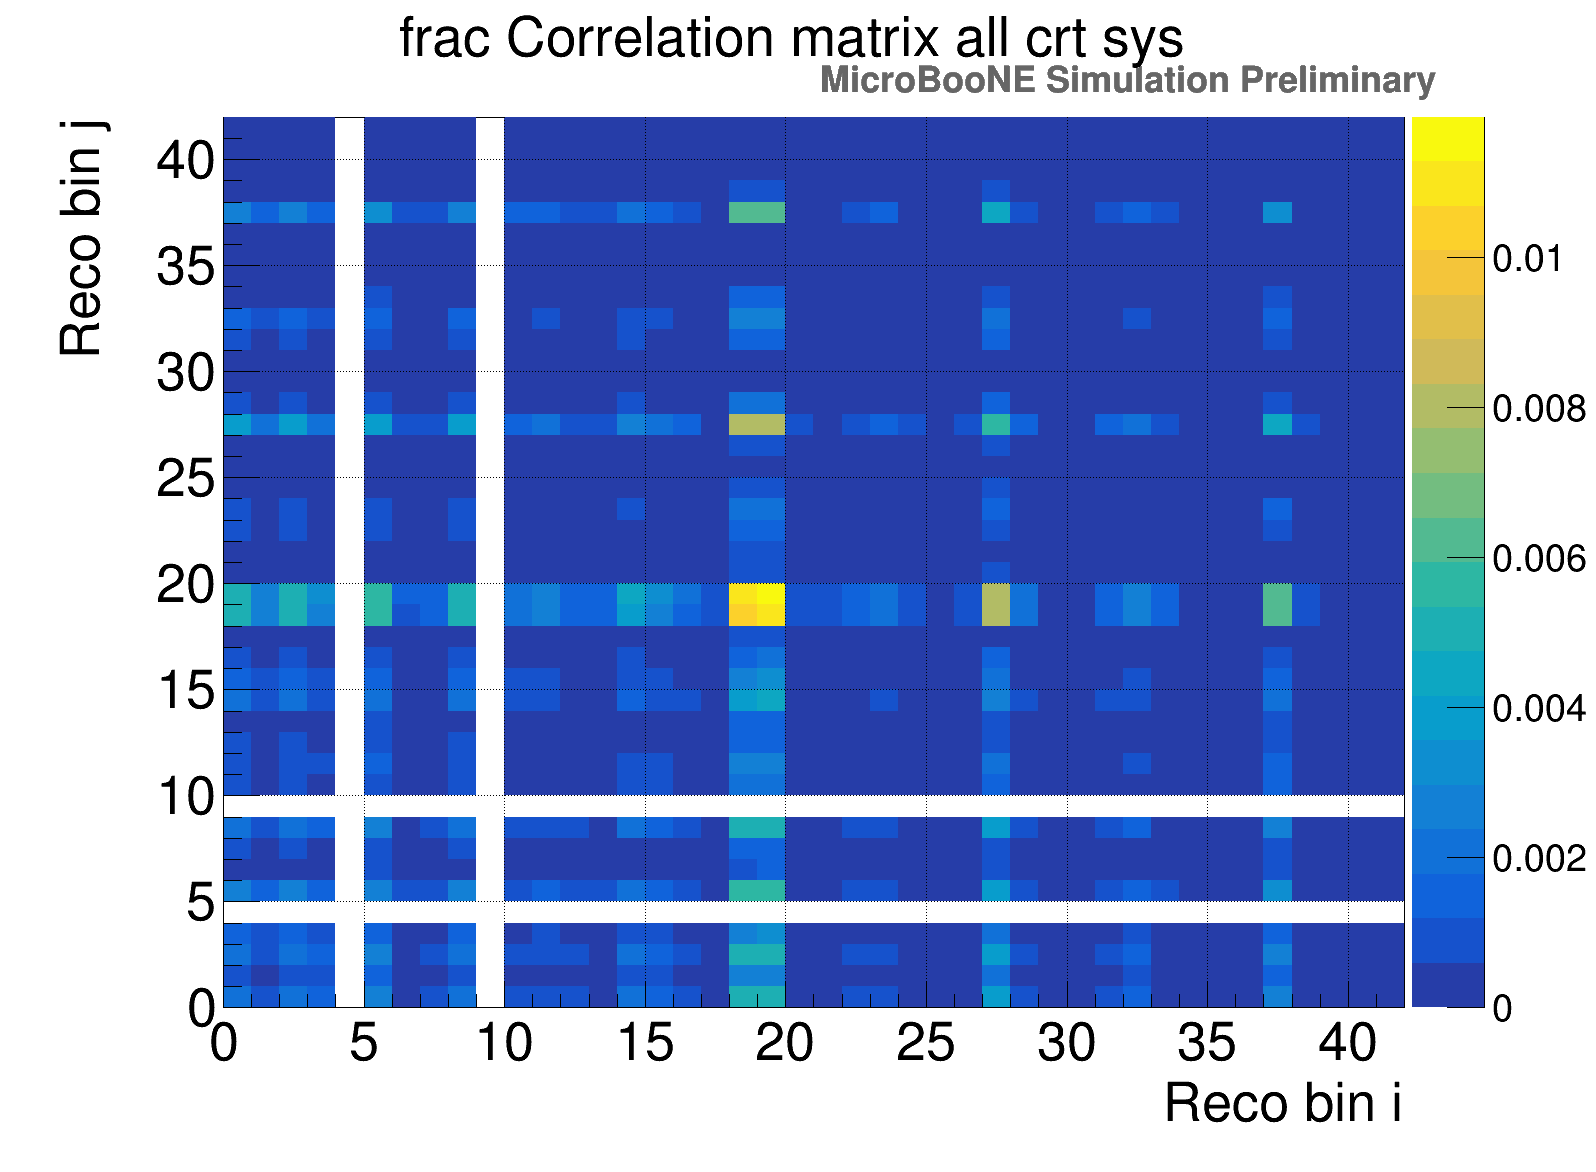

In [26]:
ROOT.gStyle.SetPaintTextFormat('0.6g')
h_covariance = ROOT.TH2D("h_covariance",'frac Correlation matrix all crt sys',sum_bins,0,sum_bins,sum_bins,0,sum_bins)
for i in range(sum_bins):
    for j in range(sum_bins):
        h_covariance.SetBinContent(i+1,j+1,xsec_frac_matrix[i,j])
#h_covariance.SetXTitle("Reco bin i, 7=overflow")
#h_covariance.SetYTitle("True bin j")
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")

h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.12)
ROOT.gStyle.SetPaintTextFormat('0.4g')

h_covariance.Draw('colz')
#h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_frac_crtsys.png")
c1.SaveAs(outputdir_root + "h_frac_crtsys.root")
c1.SaveAs(outputdir_pdf + "h_frac_crtsys.pdf")
#h_covariance.Write('h_covariance')
RootFile = ROOT.TFile(output_filedir+"Crt_systematic_2D.root","update");
h_covariance.Write('h_frac_covariance')
RootFile.Close()  

In [28]:
ROOT.gStyle.SetOptTitle(1)
bin_counter = 0
for t_bin in range(len_theta): #len_theta
    print 'Teha bin: ', t_bin
    legend = ROOT.TLegend(0.55,0.35,0.9,0.9); #LEGEND RIGHT
    legend.AddEntry(h_xsec_data[t_bin],'CV, stat. err.',"f")
    legend.AddEntry(h_xsec_crt[t_bin],'90% CRT eff.',"f")
    c1 = ROOT.TCanvas("c1","c1",1600,1200)
    c1.SetGrid(1)
    c1.SetLeftMargin(0.14)
    c1.SetRightMargin(0.1)
    c1.SetBottomMargin(0.1)

    c1.cd()
    pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
    pad1.SetGrid(1)
    pad1.Draw()
    pad1.cd()
    pad1.SetBottomMargin(0.03);
    pad1.SetTopMargin(0.1)
    
    h_xsec_data[t_bin].SetLineColorAlpha(1,0.8)
    h_xsec_data[t_bin].SetTitle(str(theta_bins[t_bin])+'< cos(#theta^{reco}_{#mu}) <'+str(theta_bins[t_bin+1]))
    h_xsec_data[t_bin].SetXTitle("p^{reco}_{#mu} [GeV]")
    h_xsec_data[t_bin].SetYTitle('#frac{#sigma^{2}}{dp_{#mu} dcos(#theta)} \t [10^{-38} #frac{cm^{2}}{GeV Nucleon}]')
    h_xsec_data[t_bin].SetMaximum(-1111)
    h_xsec_data[t_bin].SetMaximum( h_xsec_data[t_bin].GetMaximum()*1.5)
    h_xsec_data[t_bin].GetYaxis().SetLabelSize(0.05);
    h_xsec_data[t_bin].GetYaxis().SetTitleSize(0.05);
    h_xsec_data[t_bin].GetYaxis().SetTitleOffset(0.8);
    h_xsec_data[t_bin].GetXaxis().SetLabelOffset(999);
    h_xsec_data[t_bin].GetXaxis().SetTitleOffset(999);
    h_xsec_data[t_bin].GetXaxis().SetLabelSize(0);
    h_xsec_data[t_bin].GetXaxis().SetTitleSize(0);
    for m_bin in range(len_mom[t_bin]):
        h_xsec_data[t_bin].SetBinError(m_bin+1,math.sqrt(cov_matrix[bin_counter][bin_counter]))
        #print bin_counter, math.sqrt(cov_matrix[bin_counter][bin_counter]),  math.sqrt(cov_matrix[bin_counter][bin_counter]/xsec_cv_vec[bin_counter]/xsec_cv_vec[bin_counter])
        bin_counter +=1
    h_xsec_data[t_bin].Draw('E1')
    h_xsec_crt[t_bin].Draw('hist same')
    h_xsec_data[t_bin].Draw('E1 same')
    legend.Draw()
    
    c1.cd()
    h_xsec_data[t_bin].GetXaxis().SetLabelOffset(0);
    h_xsec_data[t_bin].GetXaxis().SetTitleOffset(0);
    pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
    pad2.SetGrid(1)
    pad2.SetTopMargin(0.04)
    pad2.SetBottomMargin(0.4)
    pad2.Draw()
    pad2.cd()
    
    h_file_cv = h_xsec_data[t_bin].Clone()
    h_file_dirt = h_xsec_crt[t_bin].Clone()
    
    for m_bin in range(len_mom[t_bin]):
        h_file_cv.SetBinError(m_bin+1,1e-80)
    h_file_cv.Divide(h_xsec_data[t_bin])
    h_file_cv.SetTitle(' ')
    h_file_cv.SetYTitle('Data/(Ext+MC)')
    h_file_cv.GetYaxis().SetTitleSize(0.1)
    h_file_cv.GetYaxis().SetTitleOffset(0.3)
    h_file_cv.GetYaxis().SetLabelSize(0.07)

    h_file_cv.GetXaxis().SetTitleSize(0.15)
    h_file_cv.GetXaxis().SetLabelSize(0.15)
    h_file_cv.GetXaxis().SetTitleOffset(1)
    h_file_cv.SetMinimum(-1111)
    h_file_cv.SetMaximum(-1111)
    h_file_cv.Draw('E1 hist')

    h_file_dirt.Divide(h_xsec_data[t_bin])
    h_file_dirt.Draw('hist same')
    h_file_cv.Draw('E1 same')
    c1.Draw()
    
    c1.SaveAs(outputdir_png + 'h_xsec_2D_'+str(t_bin)+'_syserr.png')
    #c1.SaveAs(outputdir_root + 'h_xsec_2D_'+str(t_bin)+'_syserr.root')
    c1.SaveAs(outputdir_pdf + 'h_xsec_2D_'+str(t_bin)+'_syserr.pdf')

    c1.Draw()
#ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Teha bin:  0
Teha bin:  1
Teha bin:  2
Teha bin:  3
Teha bin:  4
Teha bin:  5
Teha bin:  6
Teha bin:  7
Teha bin:  8


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/png/h_xsec_2D_0_syserr.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/pdf/h_xsec_2D_0_syserr.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/png/h_xsec_2D_1_syserr.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/pdf/h_xsec_2D_1_syserr.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_crt_2D_mar18/png/h_xsec_2D_

In [29]:
# close the root file with all the histos
RootFile.Close()